# **Load the Dataset**
Download the dataset to the drive to access it later on

In [1]:
!wget http://download.tensorflow.org/example_images/flower_photos.tgz


--2020-10-03 22:35:01--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   133MB/s    in 1.6s    

2020-10-03 22:35:03 (133 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [2]:
!ls 

flower_photos.tgz  sample_data


In [3]:
!tar -xvzf flower_photos.tgz

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

# **Preprocess the data**
Read the images and convert them to a dictionary of dictionaries. Each sub-dictionary has the name of the image as the key, and the pixels as value. The key of each dictionary is its folder name.

## Get insight about the sizes


In [4]:
import skimage.io
from skimage.transform import resize
import os
import sys
from skimage.color import rgb2gray
import cupy as cp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


In [5]:
def get_images(path='flower_photos/' ,gray=False):
    img_dict = dict()

    min_width, min_height =  (32,32)

    for root, dirs, files in os.walk(path):
        print(os.path.basename(root))
        my_key = os.path.basename(root)

        dir_images = dict()
        for file_ in files:
            full_file_path = os.path.join(root, file_)
            if(full_file_path.split('.')[1]=='jpg'):
                img = skimage.io.imread(fname=full_file_path)
                img = resize(image = img , output_shape=(min_width, min_height))
                if gray:
                    img  = rgb2gray(img)
                    dir_images[file_] = cp.asarray(img)
                else:
                    dir_images[file_] = cp.asarray(img)

        img_dict[my_key] = dir_images
    return img_dict


In [6]:
img_dict = get_images()
for label in img_dict:
  print(label)
  print(len(img_dict[label]))



sunflowers
tulips
dandelion
roses
daisy

0
sunflowers
699
tulips
799
dandelion
898
roses
641
daisy
633


In [7]:
def sort_data(img_dict):
    for label in img_dict:
        img_dict[label] = dict(sorted(img_dict[label].items()))
    return img_dict
img_dict = sort_data(img_dict)


In [8]:
def partition_train_test(img_dict, part = True):
    X_train = list()
    labels = list()
    X_test = list()
    Y_test = list()
    test_tabels = {}
    dic_labels = {}
    counter = 0
    for label in img_dict:
      if label :
        dic_labels[label] = counter
        test_tabels[counter] = label
        counter += 1
    if part:
        for label in img_dict:
          if(label):
            X_test.extend(list(img_dict[label].values())[-100:])
            for i in range(100):
              Y_test.append(dic_labels[label])
              
        for label in img_dict:
          img_dict[label] = {key: value for key, value in list(img_dict[label].items())[:-100]}


    for label in img_dict:
      for img in img_dict[label]:
        if label:
          labels.append(dic_labels[label])
          X_train.append(img_dict[label][img])
          #print(img_dict[label][img].shape)
    X_train = cp.array(X_train)
    X_test = cp.array(X_test)
    Y_train = cp.vstack(labels)
    Y_test = cp.vstack(Y_test)

    return X_train, Y_train, X_test, Y_test, test_tabels

## Sort the files inside each directory

In [9]:
X_train, Y_train, X_test, Y_test, test_labels = partition_train_test(img_dict)
#print(X_test[1])
#print(X_train[:10])
#print(labels[:10])
print(X_train.shape)

(3170, 32, 32, 3)


In [10]:
# Reshape the image data into rows
def flatten_data(X_train, X_test):
    print (X_train.shape, X_test.shape)
    X_train = cp.reshape(X_train, (X_train.shape[0], -1))
    X_test = cp.reshape(X_test, (X_test.shape[0], -1))
    print (X_train.shape, X_test.shape)
    return X_train, X_test

X_train, X_test = flatten_data(X_train, X_test) 

(3170, 32, 32, 3) (500, 32, 32, 3)
(3170, 3072) (500, 3072)


In [11]:
from tqdm.notebook import tqdm

class KNearestNeighbor(object):
    #http://cs231n.github.io/classification/
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # the nearest neighbor classifier simply remembers all the training data
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k ,  l='L1'):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        Ys_k=[]
        Ypred = cp.zeros(num_test, dtype = self.ytr.dtype)
        # loop over all test rows
        for i in tqdm(range(num_test)):
            # find the nearest training example to the i'th test example
            if l == 'L1':
                # using the L1 distance (sum of absolute value differences)
                distances = cp.sum(cp.abs(self.Xtr - X[i,:]), axis = 1)
            else:
                distances = cp.sqrt(cp.sum(cp.square(self.Xtr - X[i,:]), axis = 1))
            #sort the distances of the required points
            sorted_distances=cp.argsort(distances)
            #take the nearest K neighbors to the required point  
            sorted_distances=sorted_distances[:k].tolist()
            #reterive the labels of the sorted distances
            Ys_k=self.ytr[sorted_distances]
            #calculate the number of occurrences of each label 
            classes, occurrences= cp.unique(Ys_k, return_counts=True)
            #print(occurrences)
            #assign te highest repeated label to the testing point
            Ypred[i]=classes[cp.argmax(occurrences)]
            
        return Ypred

In [14]:
classifier = KNearestNeighbor()


In [24]:
# Divide the Dataset to 5 parts
def fold_data(img_dict):
  total_size = Y_train.shape[0]
  fold_size = {}
  dic_labels = {}
  counter = 0
  for label in img_dict:
    fold_size[label] = int(len(img_dict[label])/5)

  for label in img_dict:
        if label :
          dic_labels[label] = counter
          counter += 1
  print(fold_size)
  X_train_folded = []
  Y_train_folded = []

  for x in range(5):
      X = []
      Y = []
      for label in img_dict:
        X.extend(list( img_dict[label].values() )[x*fold_size[label]:(x+1)*fold_size[label] ])
        for i in range(fold_size[label]):
          Y.append(dic_labels[label])
      X_train_folded.append(X)
      Y_train_folded.append(cp.vstack(Y))
  print('done')

  X_train_folded = cp.asarray(X_train_folded)
  Y_train_folded = cp.asarray(Y_train_folded)
  X_train_folded = cp.reshape(X_train_folded,(X_train_folded.shape[0],X_train_folded.shape[1],-1))
  return X_train_folded, Y_train_folded

X_train_folded, Y_train_folded = fold_data(img_dict)

{'': 0, 'sunflowers': 119, 'tulips': 139, 'dandelion': 159, 'roses': 108, 'daisy': 106}
done


In [16]:
  # Loop over the wanted K values and do 5-crossfold
k_values = [1,2,3,4,5,6,7,8,9,10,20,50,100]
accuracies = {}
folds = 5
print(k_values)
fold_size = int(X_train.shape[0]/folds)

for k in k_values:
    accuracies[k] = []
    for f in range(folds):
        x_train_model = cp.concatenate( [X_train_folded[i] for i in range(folds) if (i != f) ])
        y_train_model = cp.concatenate( [Y_train_folded[i] for i in range(folds) if (i != f)] )
        
        x_val_model = cp.concatenate( [X_train_folded[i] for i in range(folds) if (i == f) ])
        y_val_model = cp.concatenate( [Y_train_folded[i] for i in range(folds) if (i == f)] )
        
        classifier.train(x_train_model, y_train_model)
        y_val_pred = cp.vstack(classifier.predict(x_val_model, k, 'L2'))
        
        # Compute and print the fraction of correctly predicted examples
        num_correct = cp.sum(y_val_pred == y_val_model)
        accuracy = float(num_correct) / fold_size
        accuracies[k].append(accuracy)
        print ('Got %d / %d correct => accuracy: %f for k %d and fold %d: ' % (num_correct, fold_size
                                                                                , accuracy, k, f+1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]



Got 226 / 634 correct => accuracy: 0.356467 for k 1 and fold 1: 



Got 214 / 634 correct => accuracy: 0.337539 for k 1 and fold 2: 



Got 244 / 634 correct => accuracy: 0.384858 for k 1 and fold 3: 



Got 218 / 634 correct => accuracy: 0.343849 for k 1 and fold 4: 



Got 235 / 634 correct => accuracy: 0.370662 for k 1 and fold 5: 



Got 231 / 634 correct => accuracy: 0.364353 for k 2 and fold 1: 



Got 219 / 634 correct => accuracy: 0.345426 for k 2 and fold 2: 



Got 234 / 634 correct => accuracy: 0.369085 for k 2 and fold 3: 



Got 232 / 634 correct => accuracy: 0.365931 for k 2 and fold 4: 



Got 244 / 634 correct => accuracy: 0.384858 for k 2 and fold 5: 



Got 236 / 634 correct => accuracy: 0.372240 for k 3 and fold 1: 



Got 211 / 634 correct => accuracy: 0.332808 for k 3 and fold 2: 



Got 240 / 634 correct => accuracy: 0.378549 for k 3 and fold 3: 



Got 246 / 634 correct => accuracy: 0.388013 for k 3 and fold 4: 



Got 237 / 634 correct => accuracy: 0.373817 for k 3 and fold 5: 



Got 244 / 634 correct => accuracy: 0.384858 for k 4 and fold 1: 



Got 221 / 634 correct => accuracy: 0.348580 for k 4 and fold 2: 



Got 236 / 634 correct => accuracy: 0.372240 for k 4 and fold 3: 



Got 244 / 634 correct => accuracy: 0.384858 for k 4 and fold 4: 



Got 236 / 634 correct => accuracy: 0.372240 for k 4 and fold 5: 



Got 246 / 634 correct => accuracy: 0.388013 for k 5 and fold 1: 



Got 219 / 634 correct => accuracy: 0.345426 for k 5 and fold 2: 



Got 245 / 634 correct => accuracy: 0.386435 for k 5 and fold 3: 



Got 245 / 634 correct => accuracy: 0.386435 for k 5 and fold 4: 



Got 248 / 634 correct => accuracy: 0.391167 for k 5 and fold 5: 



Got 245 / 634 correct => accuracy: 0.386435 for k 6 and fold 1: 



Got 216 / 634 correct => accuracy: 0.340694 for k 6 and fold 2: 



Got 234 / 634 correct => accuracy: 0.369085 for k 6 and fold 3: 



Got 252 / 634 correct => accuracy: 0.397476 for k 6 and fold 4: 



Got 245 / 634 correct => accuracy: 0.386435 for k 6 and fold 5: 



Got 234 / 634 correct => accuracy: 0.369085 for k 7 and fold 1: 



Got 216 / 634 correct => accuracy: 0.340694 for k 7 and fold 2: 



Got 241 / 634 correct => accuracy: 0.380126 for k 7 and fold 3: 



Got 249 / 634 correct => accuracy: 0.392744 for k 7 and fold 4: 



Got 248 / 634 correct => accuracy: 0.391167 for k 7 and fold 5: 



Got 239 / 634 correct => accuracy: 0.376972 for k 8 and fold 1: 



Got 217 / 634 correct => accuracy: 0.342271 for k 8 and fold 2: 



Got 247 / 634 correct => accuracy: 0.389590 for k 8 and fold 3: 



Got 240 / 634 correct => accuracy: 0.378549 for k 8 and fold 4: 



Got 233 / 634 correct => accuracy: 0.367508 for k 8 and fold 5: 



Got 244 / 634 correct => accuracy: 0.384858 for k 9 and fold 1: 



Got 217 / 634 correct => accuracy: 0.342271 for k 9 and fold 2: 



Got 252 / 634 correct => accuracy: 0.397476 for k 9 and fold 3: 



Got 245 / 634 correct => accuracy: 0.386435 for k 9 and fold 4: 



Got 243 / 634 correct => accuracy: 0.383281 for k 9 and fold 5: 



Got 236 / 634 correct => accuracy: 0.372240 for k 10 and fold 1: 



Got 216 / 634 correct => accuracy: 0.340694 for k 10 and fold 2: 



Got 251 / 634 correct => accuracy: 0.395899 for k 10 and fold 3: 



Got 242 / 634 correct => accuracy: 0.381703 for k 10 and fold 4: 



Got 243 / 634 correct => accuracy: 0.383281 for k 10 and fold 5: 



Got 227 / 634 correct => accuracy: 0.358044 for k 20 and fold 1: 



Got 225 / 634 correct => accuracy: 0.354890 for k 20 and fold 2: 



Got 251 / 634 correct => accuracy: 0.395899 for k 20 and fold 3: 



Got 238 / 634 correct => accuracy: 0.375394 for k 20 and fold 4: 



Got 238 / 634 correct => accuracy: 0.375394 for k 20 and fold 5: 



Got 227 / 634 correct => accuracy: 0.358044 for k 50 and fold 1: 



Got 220 / 634 correct => accuracy: 0.347003 for k 50 and fold 2: 



Got 237 / 634 correct => accuracy: 0.373817 for k 50 and fold 3: 



Got 229 / 634 correct => accuracy: 0.361199 for k 50 and fold 4: 



Got 239 / 634 correct => accuracy: 0.376972 for k 50 and fold 5: 



Got 211 / 634 correct => accuracy: 0.332808 for k 100 and fold 1: 



Got 208 / 634 correct => accuracy: 0.328076 for k 100 and fold 2: 



Got 230 / 634 correct => accuracy: 0.362776 for k 100 and fold 3: 



Got 221 / 634 correct => accuracy: 0.348580 for k 100 and fold 4: 



Got 226 / 634 correct => accuracy: 0.356467 for k 100 and fold 5: 


In [17]:
import operator

# find the best k in terms of average and standard deviation
acc_analysis = {}

for k in accuracies:
    if k:
        tmp = cp.vstack(accuracies[k])
        acc_analysis[k] = ( cp.average(tmp), cp.std(tmp) )

#print(sorted(accuracies.items(), key=lambda x: x[1], reverse=True))
print(acc_analysis)
print(sorted(acc_analysis.items(), key=lambda x: x[1], reverse=True))

{1: (array(0.35867508), array(0.01732433)), 2: (array(0.3659306), array(0.0125788)), 3: (array(0.36908517), array(0.01895371)), 4: (array(0.37255521), array(0.01324921)), 5: (array(0.37949527), array(0.0171221)), 6: (array(0.37602524), array(0.0198663)), 7: (array(0.37476341), array(0.01904799)), 8: (array(0.37097792), array(0.01597349)), 9: (array(0.37886435), array(0.01896421)), 10: (array(0.37476341), array(0.01862535)), 20: (array(0.37192429), array(0.01470857)), 50: (array(0.36340694), array(0.01090954)), 100: (array(0.34574132), array(0.0133614))}
[(5, (array(0.37949527), array(0.0171221))), (9, (array(0.37886435), array(0.01896421))), (6, (array(0.37602524), array(0.0198663))), (7, (array(0.37476341), array(0.01904799))), (10, (array(0.37476341), array(0.01862535))), (4, (array(0.37255521), array(0.01324921))), (20, (array(0.37192429), array(0.01470857))), (8, (array(0.37097792), array(0.01597349))), (3, (array(0.36908517), array(0.01895371))), (2, (array(0.3659306), array(0.012

In [18]:
acc_analysis

{1: (array(0.35867508), array(0.01732433)),
 2: (array(0.3659306), array(0.0125788)),
 3: (array(0.36908517), array(0.01895371)),
 4: (array(0.37255521), array(0.01324921)),
 5: (array(0.37949527), array(0.0171221)),
 6: (array(0.37602524), array(0.0198663)),
 7: (array(0.37476341), array(0.01904799)),
 8: (array(0.37097792), array(0.01597349)),
 9: (array(0.37886435), array(0.01896421)),
 10: (array(0.37476341), array(0.01862535)),
 20: (array(0.37192429), array(0.01470857)),
 50: (array(0.36340694), array(0.01090954)),
 100: (array(0.34574132), array(0.0133614))}

In [19]:
sorted_accuracies = dict(sorted(acc_analysis.items(), key= lambda item: (item[1][0],item[1],[1]), reverse=True))
best_k  = max(acc_analysis.items(), key=operator.itemgetter(1))[0]
print(best_k)
print(sorted_accuracies[best_k])
th = 1.01
count = 0
for k in sorted_accuracies:
  if k is not best_k:
    if count == 5:
      break
    if sorted_accuracies[best_k][1] > th*sorted_accuracies[k][1]:
      best_k = k
      print(k, sorted_accuracies[best_k])
    count += 1
    

print(best_k)

5
(array(0.37949527), array(0.0171221))
4 (array(0.37255521), array(0.01324921))
4


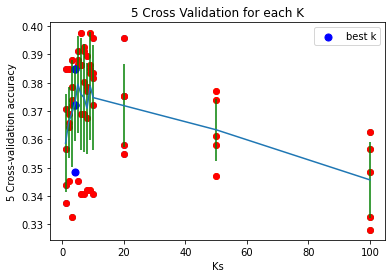

In [20]:

# plot the raw observations
for k in k_values:
  if k:
    accuuracies_list = accuracies[k]
    plt.scatter([k] * len(accuuracies_list), accuuracies_list)
x_values = []
y_values = []


# plot the raw observations
for k in k_values:
  if k != best_k:
    for i in range(5):
      x_values.append(k)
    y_values.extend(accuracies[k])

plt.scatter(x_values, y_values,c='red', )
plt.scatter([best_k]* len(accuracies[best_k]), accuracies[best_k], c='blue', label='best k', s = 50)
    
# plot the trend line with error bars that correspond to standard deviation
Mean = cp.array([cp.mean(cp.array(value)) for k,value in sorted(accuracies.items())])
standard_deviation = cp.array([cp.std(cp.array(value)) for k,value in sorted(accuracies.items())])

plt.errorbar(cp.asnumpy(k_values), cp.asnumpy(Mean), yerr=cp.asnumpy(standard_deviation), ecolor='green')
plt.title('5 Cross Validation for each K')
plt.xlabel('Ks')
plt.ylabel('5 Cross-validation accuracy')
plt.legend()
plt.show()

In [21]:
classifier.train(X_train,Y_train)
# trying the testing data
y_test_pred = cp.vstack(classifier.predict(X_test, best_k, 'L2'))
# Compute and print the fraction of correctly predicted examples
test_labels[int(cp.asnumpy(Y_test[i*100+1]))]
for i in range(5):
    accuracy = float(num_correct) / 500
    num_correct = cp.sum(y_test_pred[i*100:(i+1)*100] == Y_test[i*100:(i+1)*100])
    print ('For colored images CCR for class %s = %d / %d correct => accuracy: %f for k %d: ' 
           % (test_labels[int(cp.asnumpy(Y_test[i*100+1]))], num_correct, 100, accuracy, best_k))
    
num_correct = cp.sum(y_test_pred == Y_test)
accuracy = float(num_correct) / 500

print ('For colored images ACCR= %d / %d correct => accuracy: %f for k %d: ' % (num_correct, 500
                                                                        , accuracy, best_k))


For colored images CCR for class sunflowers = 58 / 100 correct => accuracy: 0.452000 for k 4: 
For colored images CCR for class tulips = 15 / 100 correct => accuracy: 0.116000 for k 4: 
For colored images CCR for class dandelion = 82 / 100 correct => accuracy: 0.030000 for k 4: 
For colored images CCR for class roses = 13 / 100 correct => accuracy: 0.164000 for k 4: 
For colored images CCR for class daisy = 5 / 100 correct => accuracy: 0.026000 for k 4: 
For colored images ACCR= 173 / 500 correct => accuracy: 0.346000 for k 4: 


In [25]:
# testing on the greyscale images
gray_dict = get_images(gray=True)
gray_dict = sort_data(gray_dict)
X_gr_train, Y_gr_train, X_gr_test, Y_gr_test, test_gr_labels = partition_train_test(gray_dict)
X_gr_train, X_gr_test = flatten_data(X_gr_train, X_gr_test) 
# Create a classifier instance and train it with training data
gray_classifier = KNearestNeighbor()
gray_classifier.train(X_gr_train, Y_gr_train)
# trying the testing data
y_gr_test_pred = cp.vstack(gray_classifier.predict(X_gr_test, best_k, 'L2'))
# Compute and print the fraction of correctly predicted examples
for i in range(5):
    num_correct = cp.sum(y_test_pred[i*100:(i+1)*100] == Y_test[i*100:(i+1)*100])
    gray_accuracy = float(num_correct) / 100
    print ('For colored images CCR for class %s = %d / %d correct => accuracy: %f for k %d: ' 
           % (test_gr_labels[int(cp.asnumpy(Y_gr_test[i*100+1]))], num_correct, 100, accuracy, best_k))
num_correct = cp.sum(y_gr_test_pred == Y_gr_test)
gray_accuracy = float(num_correct) / 500
print ('for Gray images: %d / %d correct => accuracy: %f for k %d: ' % (num_correct, 500
                                                          , gray_accuracy, best_k))


sunflowers
tulips
dandelion
roses
daisy
(3170, 32, 32) (500, 32, 32)
(3170, 1024) (500, 1024)



For colored images CCR for class sunflowers = 58 / 100 correct => accuracy: 0.346000 for k 4: 
For colored images CCR for class tulips = 15 / 100 correct => accuracy: 0.346000 for k 4: 
For colored images CCR for class dandelion = 82 / 100 correct => accuracy: 0.346000 for k 4: 
For colored images CCR for class roses = 13 / 100 correct => accuracy: 0.346000 for k 4: 
For colored images CCR for class daisy = 5 / 100 correct => accuracy: 0.346000 for k 4: 
for Gray images: 147 / 500 correct => accuracy: 0.294000 for k 4: 
